In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:

words = open('names.txt', 'r').read().splitlines()
words[:8]
len(words)


32033

In [51]:

# dictionary of encoding characters
chars = sorted(set(''.join(words)))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [52]:


# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [53]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [57]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)# * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) #* 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) #* 0.01
b2 = torch.randn(vocab_size,                      generator=g) #* 0

"""# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]"""
parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


11697


In [58]:
lossi = []

0/200000: 24.62901496887207
10000/200000: 2.183363437652588
20000/200000: 2.637066602706909
30000/200000: 2.5162272453308105
40000/200000: 2.1382689476013184
50000/200000: 2.3173234462738037
60000/200000: 2.392282009124756
70000/200000: 2.389132261276245
80000/200000: 2.133803129196167
90000/200000: 2.2054965496063232
100000/200000: 2.545994758605957
110000/200000: 2.09959077835083
120000/200000: 2.107985019683838
130000/200000: 2.6260128021240234
140000/200000: 2.157224655151367
150000/200000: 2.0686163902282715
160000/200000: 1.9070507287979126
170000/200000: 2.1632773876190186
180000/200000: 1.7895387411117554
190000/200000: 2.1596503257751465
2.1061642169952393
2.150301456451416


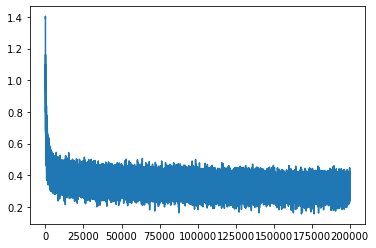

In [59]:
batch_size = 48
steps = 200000

for i in range(steps):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    lr = 0.1 if i < 100000 else 0.05 if i < 150000 else 0.01

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
      print(f'{i}/{steps}: {loss.item()}')

# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev).item())

plt.plot(torch.arange(len(lossi)), lossi)

#### Things:

In [61]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [62]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 4.708397388458252
val 4.712019920349121


### Observation

As we can see, when we initialize the parameters, the loss is really **big**. That means that we have really confident bad predictions. At the start, what we actually want is to be equally confident on any prediction, that would be 1/27:

In [60]:
-torch.tensor(1/27).log()

tensor(3.2958)

Really lower than 24 or so on.

Let's see that if we initialize every param with the same value, we get equal probability and maintain the loss low. If we predict very confidently wrong, loss grows:

In [66]:
logits = torch.tensor([0., 0., 0., 0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print( probs, loss)

logits = torch.tensor([0., 0., 5., 0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print( probs, loss)

logits = torch.tensor([0., 5., 0., 0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print( probs, loss)



tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)
tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(5.0200)


#### Let's initialize params propperly:

At first, we have a loss of 24, and params are sometimes really big, we dont want that.

In [78]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)# * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

"""# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]"""
parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

lossi = []

11697


0/2000: 3.2977490425109863


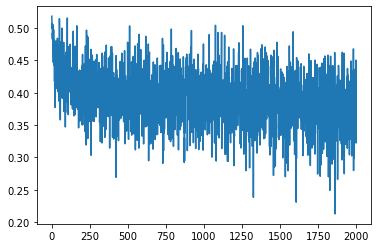

In [80]:
batch_size = 32
steps = 2000

for i in range(steps):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    lr = 0.1 if i < 100000 else 0.05 if i < 150000 else 0.01

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
      print(f'{i}/{steps}: {loss.item()}') 
    
    #break

"""# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev).item())"""

plt.plot(torch.arange(len(lossi)), lossi)

We can note here we have supressed the 'easy' part of training where we had the 'hockey stick' figure. Now we have a more straight curve.

In [81]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4742350578308105
val 2.4893157482147217


#### Another problem

In [82]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)# * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

"""# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]"""
parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

lossi = []

11697


In [88]:
batch_size = 32
steps = 2000

for i in range(steps):

    #mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    hpreact = emb.view(-1, n_embd*block_size) @ W1 + b1
    h = torch.tanh(hpreact)# in production, you don't want to hardcode magic numbers like this
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # set the gradients to zero
    loss.backward() # compute the gradients

    lossi.append(loss.log10().item())
    lr = 0.1 if i < 100000 else 0.05 if i < 150000 else 0.01

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
      print(f'{i}/{steps}: {loss.item()}') 
    
    break

"""# forward pass
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ytr).item())

# forward pass
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)
logits = h @ W2 + b2
print(F.cross_entropy(logits, Ydev).item())"""

#plt.plot(torch.arange(len(lossi)), lossi)

0/2000: 3.2861714363098145


'# forward pass\nemb = C[Xtr]\nh = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)\nlogits = h @ W2 + b2\nprint(F.cross_entropy(logits, Ytr).item())\n\n# forward pass\nemb = C[Xdev]\nh = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + b1)\nlogits = h @ W2 + b2\nprint(F.cross_entropy(logits, Ydev).item())'

In [89]:
h.shape

torch.Size([32, 200])

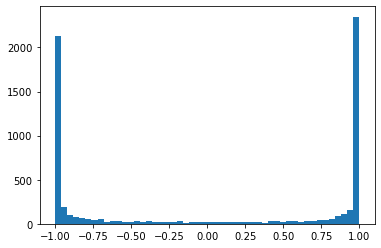

In [90]:
plt.hist(h.view(-1).tolist(), 50);

As we can see the values in 'h' are almost always 1 or -1. 

But alto, if we do the same to the data without activation, it has a more broad distribution.

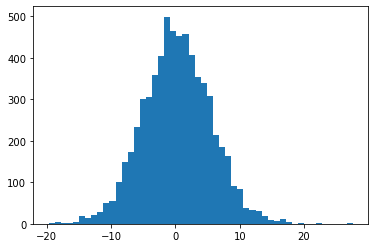

In [91]:
plt.hist(hpreact.view(-1).tolist(), 50);